# Visualize results Segmentation

In [1]:
# imports 
import numpy as np
from monai.transforms import (
    Compose,
    LoadImaged,
    LoadImage,
    ScaleIntensityd,
    MapLabelValued,
    AsDiscrete
)
from monai.data import  decollate_batch

from monai.data import Dataset, DataLoader
import os

import matplotlib.pyplot as plt
import glob
import pytorch_lightning as pl
import torch

import torch

from monai.networks.nets import UNet

from helpers import UNet_model, MMWHS_single

2024-05-28 12:28:18.717142: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 12:28:18.792932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 12:28:18.793005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 12:28:18.794752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 12:28:18.807941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

In [2]:
pl.seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Seed set to 42


In [7]:
def get_output_unet(image, model_name, unet=True):
    if unet:
        model = UNet_model(2).to(device)
    else: 
        model = UNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
        ).to(device)
    pretrained_model = glob.glob(os.path.join(model_name, "*.pth"))[0]
    # Load the state dictionary
    model.load_state_dict(torch.load(pretrained_model, map_location=torch.device('cpu')))
    model.eval()
    post_trans = Compose([AsDiscrete(argmax=True)])
    outputs = model.forward(image.to(device)).detach().cpu()
    vis_outputs = post_trans(outputs[0])
    return vis_outputs
    

In [44]:
def visualize_baselines(output_FS, output_NA, output_DU, output_DR, image, gt, label):
    if label == "Myocardium":
        cmap_label = 'bwr'

    masked_gt = np.ma.masked_where(gt[0, 0, :, :] == 0, gt[0, 0, :, :])
    masked_output_FS = np.ma.masked_where(output_FS[0, :, :] == 0, output_FS[0, :, :])
    masked_output_NA = np.ma.masked_where(output_NA[0, :, :] == 0, output_NA[0, :, :])
    masked_output_DU = np.ma.masked_where(output_DU[0, :, :] == 0, output_DU[0, :, :])
    masked_output_DR = np.ma.masked_where(output_DR[0, :, :] == 0, output_DR[0, :, :])
    
    plt.figure("visualize", (24, 6))
    plt.subplot(1, 6, 1)
    plt.title("Input Image")
    plt.ylabel(label)
    plt.imshow(image[0, 0, :, :], cmap="gray")
    plt.axis("off")
    plt.subplot(1, 6, 2)
    plt.title("UNet (NA)")
    plt.imshow(image[0, 0, :, :], cmap="gray")
    plt.imshow(masked_output_NA, alpha=0.3,  cmap=cmap_label)
    plt.axis("off")
    plt.subplot(1, 6, 3)
    plt.title("DRIT + UNet")
    plt.imshow(image[0, 0, :, :], cmap="gray")
    plt.imshow(masked_output_DU, alpha=0.3,  cmap=cmap_label)
    plt.axis("off")
    plt.subplot(1, 6, 4)
    plt.title("DRIT + RUNet")
    plt.imshow(image[0, 0, :, :], cmap="gray")
    plt.imshow(masked_output_DR, alpha=0.3,  cmap=cmap_label)
    plt.axis("off")
    plt.subplot(1, 6, 5)
    plt.title("UNet (FS)")
    plt.imshow(image[0, 0, :, :], cmap="gray")
    plt.imshow(masked_output_FS, alpha=0.3,  cmap=cmap_label)
    plt.axis("off")
    plt.subplot(1, 6, 6)
    plt.title("Ground Truth")
    plt.imshow(image[0, 0, :, :], cmap="gray")
    plt.imshow(masked_gt, alpha=0.3, cmap=cmap_label)
    plt.axis("off")
    plt.tight_layout()  
    
    plt.show()



## MRI --> CT

In [42]:
data_dir = "../data/other/CT_withGT_proc/annotated"

test_cases_fold_0 = [0, 1, 15, 17]
labels = [1, 0, 0, 0, 0, 0, 0]
dataset_test = MMWHS_single(data_dir, test_cases_fold_0, labels) 
test_loader = DataLoader(dataset_test, batch_size=1, num_workers=4)

../data/other/CT_withGT_proc/annotated


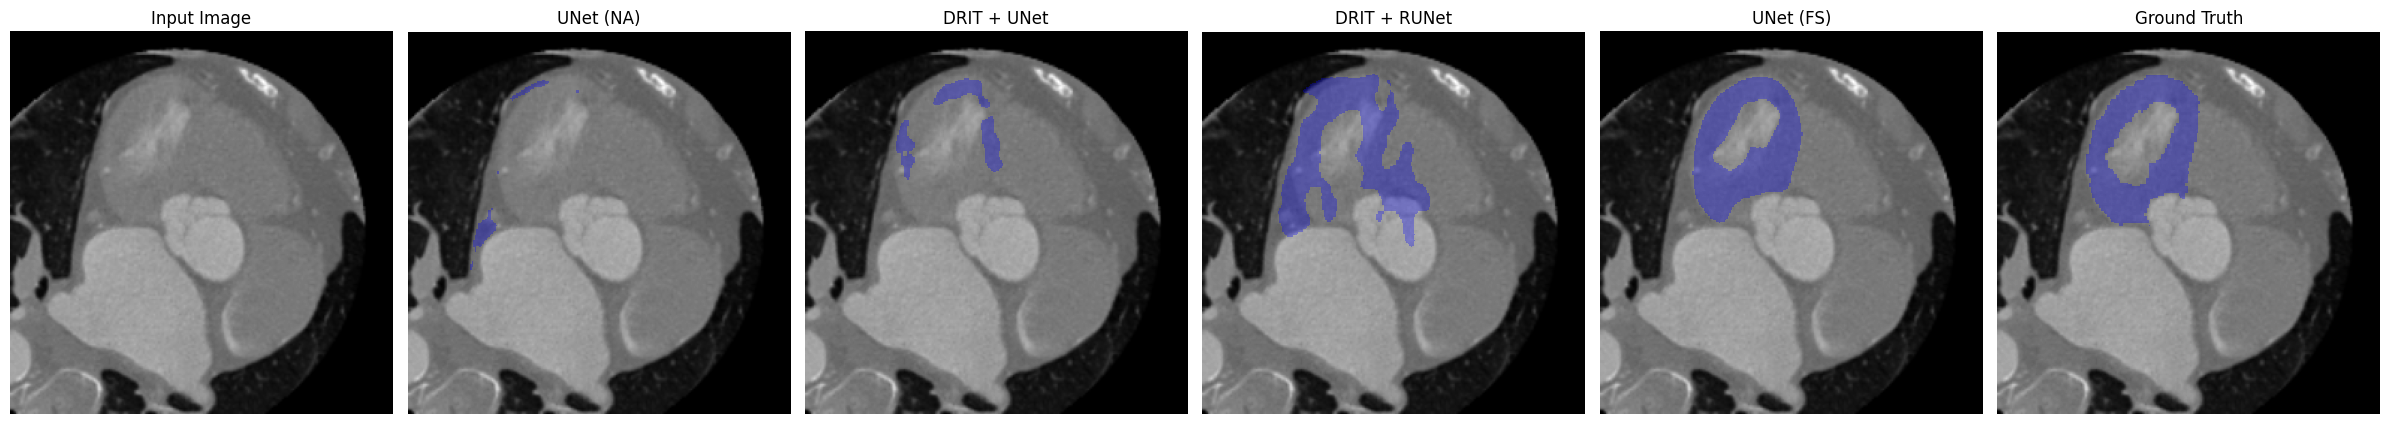

In [46]:
visualize_baselines(output_FS_MYO, output_NA_MYO, output_DU_MYO, output_DR_MYO, image, gt, "Myocardium")

TypeError: Invalid shape (1, 256, 256) for image data

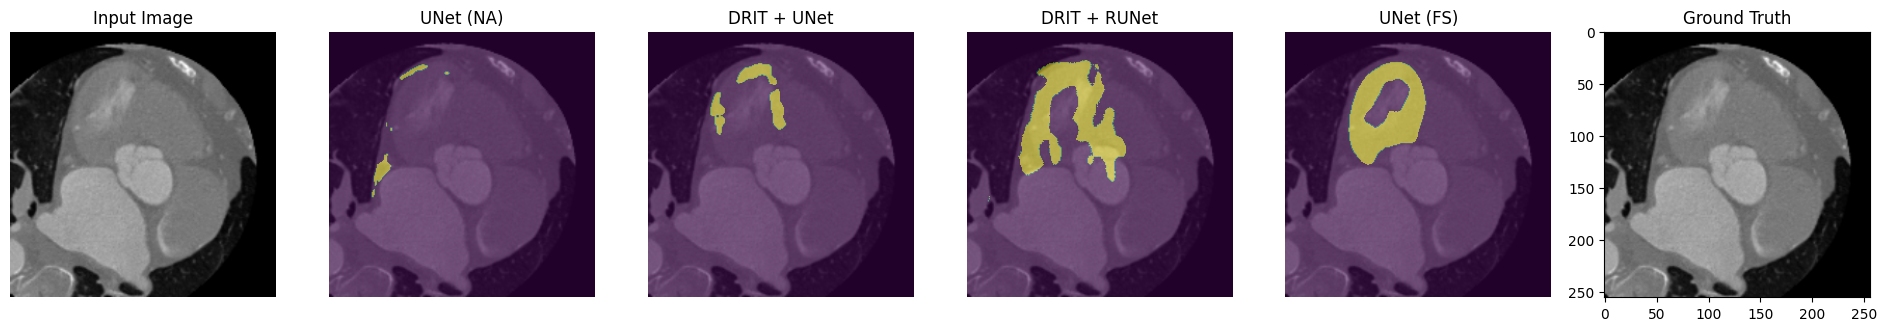

In [10]:
name_FS_MYO = '../baselines/checkpoints/Training_CT_UNET_MYO/fold_0/'
name_FS_LV = '../baselines/checkpoints/Training_CT_UNET_LV/fold_0/'
name_FS_RV = '../baselines/checkpoints/Training_CT_UNET_RV/fold_0/'
name_NA_MYO = '../baselines/checkpoints/Training_MRI_UNET_MYO/fold_0/'
name_NA_LV = '../baselines/checkpoints/Training_MRI_UNET_LV/fold_0/'
name_NA_RV = '../baselines/checkpoints/Training_MRI_UNET_RV/fold_0/'
name_DU_MYO = '../baselines/checkpoints/Training_fake_CT_UNET_MYO/fold_0/'
name_DU_LV = '../baselines/checkpoints/Training_fake_CT_UNET_LV/fold_0/'
name_DU_RV = '../baselines/checkpoints/Training_fake_CT_UNET_RV/fold_0/'
name_DR_MYO = '../baselines/checkpoints/Training_fake_CT_MYO/fold_0/'
name_DR_LV = '../baselines/checkpoints/Training_fake_CT_LV/fold_0/'
name_DR_RV = '../baselines/checkpoints/Training_fake_CT_RV/fold_0/'


for i, (im, lab) in enumerate(test_loader):
    if i == 0:
        image = im
        gt = lab
        break

print("Fully Supervised")
output_FS_MYO = get_output_unet(image, name_FS_MYO)
print("No Adaptation")
output_NA_MYO = get_output_unet(image, name_NA_MYO)
print("DRIT + UNet")
output_DU_MYO = get_output_unet(image, name_DU_MYO)
print("DRIT + ResUnet")
output_DR_MYO = get_output_unet(image, name_DR_MYO, False)

visualize_baselines(output_FS_MYO, output_NA_MYO, output_DU_MYO, output_DR_MYO, image, gt, "MYO")
